## What are the 100 most popular in the first half of 2020?

We use the top 100 songs in Spotify and use a metric that is clearly related to success, in this case popularity

## Understanding our data
Understand the dataset

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

In [13]:
import json
import os
import webbrowser
from json.decoder import JSONDecodeError
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import sys

In [17]:
df = pd.read_csv("data.csv")
print("df shape: ", df.shape)
df.head(5)

df shape:  (169909, 19)


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


/home/cs582/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 <a list of 100 Text xticklabel objects>)

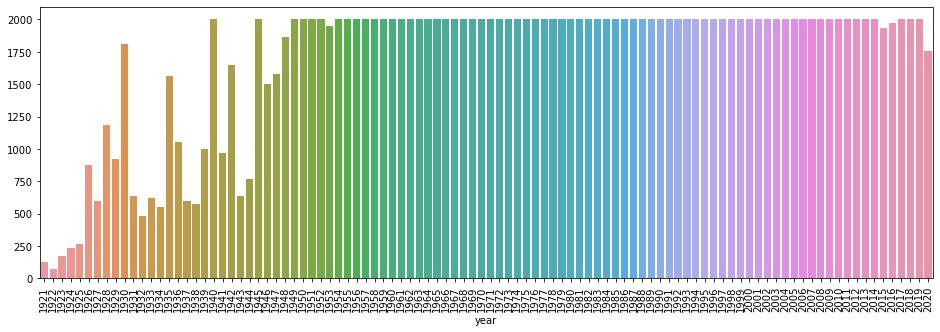

In [3]:
songs_per_year = df.groupby("year").count()["name"]
y = songs_per_year.values
x = songs_per_year.index
figure = plt.figure(figsize = (16, 5))
sns.barplot(x, y)
plt.xticks(rotation = 90)

## Data cleaning find the genre of each song

Find missing values, outliers, duplicates, find hidden metrics, etc...

In [18]:
df.head(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


## Find missing values and duplicates
Find if there are missing values in the dataset or duplicate songs

In [7]:
df_2020.isnull().any()

acousticness        False
artists             False
danceability        False
duration_ms         False
energy              False
explicit            False
id                  False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
name                False
popularity          False
release_date        False
speechiness         False
tempo               False
valence             False
year                False
dtype: bool

In [8]:
print("df_2020 shape before clearning ", df_2020.shape)
df_unique = df_2020.drop_duplicates(["name", "artists"])
print("df_unique shape after cleaning", df_unique.shape)

df_2020 shape before clearning  (1756, 19)
df_unique shape after cleaning (1606, 19)


## Creating new columns in de dataframe
Simply find the number of days since the release up to October 12th and convert duration from ms to seconds

In [9]:
def strToDate(x):
    return datetime.strptime(x, "%Y-%m-%d")

all_dates = df_unique["release_date"].apply(lambda x: strToDate(x))
date = strToDate("2020-10-12")
days_from_release = (date - all_dates).apply(lambda x: int(str(x).split()[0]))
print(days_from_release.shape[0], "songs")
duration_sec = df_unique["duration_ms"] / 1000
print(duration_sec.shape[0], "songs")
days_from_release.head(5)

1606 songs
1606 songs


87942    206
87940    178
87949    247
87941    171
87946    192
Name: release_date, dtype: int64

In [10]:
print(df_unique.shape)
df_unique["days_from_release"] = days_from_release.values
print(df_unique.shape)
df_unique["duration_sec"] = duration_sec.values
print(df_unique.shape)
df_unique.head(5)

(1606, 19)
(1606, 20)
(1606, 21)


/home/cs582/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/cs582/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,mode,name,popularity,release_date,speechiness,tempo,valence,year,days_from_release,duration_sec
87942,0.00146,['The Weeknd'],0.514,200040,0.730,0,0VjIjW4GlUZAMYd2vXMi3b,0.000095,1,0.0897,...,1,Blinding Lights,100,2020-03-20,0.0598,171.005,0.334,2020,206,200.040
87940,0.24700,"['DaBaby', 'Roddy Ricch']",0.746,181733,0.690,1,7ytR5pFWmSjzHJIeQkgog4,0.000000,11,0.1010,...,1,ROCKSTAR (feat. Roddy Ricch),99,2020-04-17,0.1640,89.977,0.497,2020,178,181.733
87949,0.73100,"['Powfu', 'beabadoobee']",0.726,173333,0.431,0,7eJMfftS33KTjuF7lTsMCx,0.000000,8,0.6960,...,0,death bed (coffee for your head) (feat. beabad...,97,2020-02-08,0.1350,144.026,0.348,2020,247,173.333
87941,0.23300,"['THE SCOTTS', 'Travis Scott', 'Kid Cudi']",0.716,165978,0.537,1,39Yp9wwQiSRIDOvrVg7mbk,0.000000,0,0.1570,...,0,THE SCOTTS,96,2020-04-24,0.0514,129.979,0.280,2020,171,165.978
87946,0.32100,['Drake'],0.834,247059,0.454,1,127QTOFJsJQp5LbJbu3A1y,0.000006,1,0.1140,...,0,Toosie Slide,95,2020-04-03,0.2010,81.618,0.837,2020,192,247.059


In [11]:
print(df_unique.shape)

(1606, 21)


/home/cs582/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'songs released during the first half of 2020')

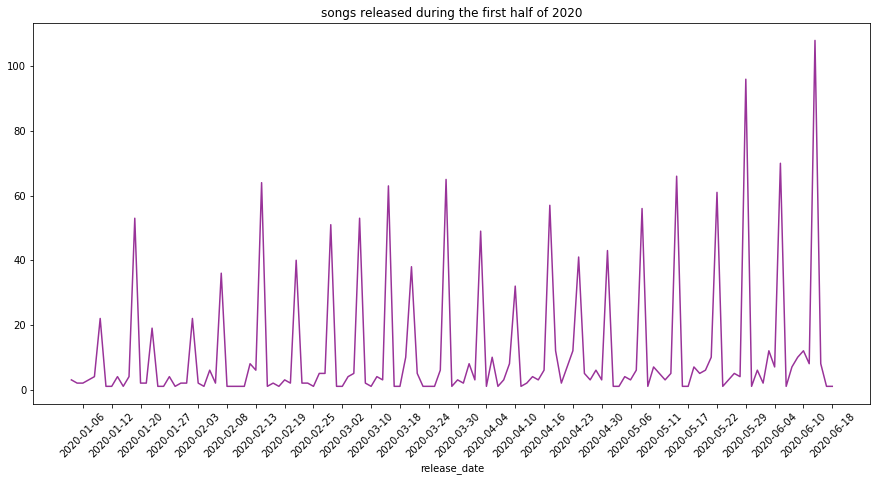

In [12]:
num_songs_2020 = df_unique[["release_date", "days_from_release"]].groupby("release_date").count()
num_songs_2020 = num_songs_2020["days_from_release"]
dates_x = num_songs_2020.index
num_songs_y = num_songs_2020.values

plt.figure(figsize = (15, 7))
fig = sns.lineplot(dates_x, num_songs_y, color = "purple", alpha = 0.8)
fig.set(xticks=dates_x[2::5])
plt.xticks(rotation = 45)
plt.title("songs released during the first half of 2020")

In [80]:
df_cleaned = df_unique.drop(["duration_ms", "id", "mode", "year"], axis = 1)
print(df_cleaned.shape)
df_cleaned.head(5)

(1606, 17)


,acousticness,artists,danceability,energy,explicit,instrumentalness,key,liveness,loudness,name,popularity,release_date,speechiness,tempo,valence,days_from_release,duration_sec
87942,0.00146,['The Weeknd'],0.514,0.730,0,0.000095,1,0.0897,-5.934,Blinding Lights,100,2020-03-20,0.0598,171.005,0.334,206,200.040
87940,0.24700,"['DaBaby', 'Roddy Ricch']",0.746,0.690,1,0.000000,11,0.1010,-7.956,ROCKSTAR (feat. Roddy Ricch),99,2020-04-17,0.1640,89.977,0.497,178,181.733
87949,0.73100,"['Powfu', 'beabadoobee']",0.726,0.431,0,0.000000,8,0.6960,-8.765,death bed (coffee for your head) (feat. beabad...,97,2020-02-08,0.1350,144.026,0.348,247,173.333
87941,0.23300,"['THE SCOTTS', 'Travis Scott', 'Kid Cudi']",0.716,0.537,1,0.000000,0,0.1570,-7.648,THE SCOTTS,96,2020-04-24,0.0514,129.979,0.280,171,165.978
87946,0.32100,['Drake'],0.834,0.454,1,0.000006,1,0.1140,-9.750,Toosie Slide,95,2020-04-03,0.2010,81.618,0.837,192,247.059


319


/home/cs582/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Release date of the most popular songs in 2020')

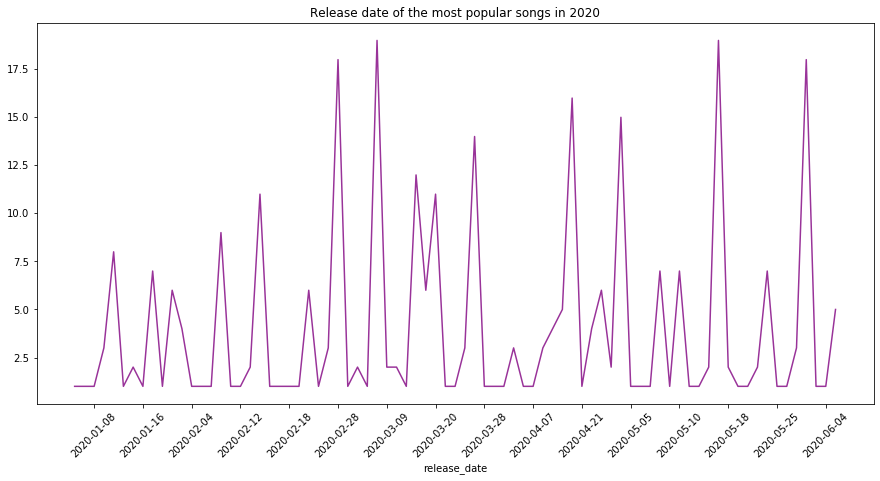

In [81]:
most_popular = df_cleaned[df_cleaned["popularity"] > 75]
print(most_popular.shape[0])

most_popular = most_popular[["release_date", "days_from_release"]].groupby("release_date").count()
most_popular = most_popular["days_from_release"]
dates_x = most_popular.index
num_songs_y = most_popular.values

plt.figure(figsize = (15, 7))
fig = sns.lineplot(dates_x, num_songs_y, color = "purple", alpha = 0.8)

fig.set(xticks=dates_x[2::5])
plt.xticks(rotation = 45)
plt.title("Release date of the most popular songs in 2020")

## What is the relationship between popularity and other parameters?

This is done in order to train the model to identify succesful and not succesful songs

In [82]:
df_cleaned.to_csv(r"df_clean_2020.csv", index = False, header = True)

In [76]:
df_cleaned.head(5)
mask_15_20 = (df["popularity"] > 50) & (df["year"] >= 2017)
mask_00_12 = (df["popularity"] > 50) & (df["year"] >= 1998) & (df["year"] <= 2004)
mask_60_75 = (df["popularity"] > 50) & (df["year"] >= 1960) & (df["year"] <= 1970)

most_pop_15_20 = df[mask_15_20]
print("2015 - 2020 is of shape ", most_pop_15_20.shape)
most_pop_00_12 = df[mask_00_12]
print("2000 - 2012 is of shape ", most_pop_00_12.shape)
most_pop_60_75 = df[mask_60_75]
print("1960 - 1975 is of shape ", most_pop_00_12.shape)

2015 - 2020 is of shape  (7557, 19)
2000 - 2012 is of shape  (4527, 19)
1960 - 1975 is of shape  (4527, 19)


Text(0.5, 0, 'Danceability')

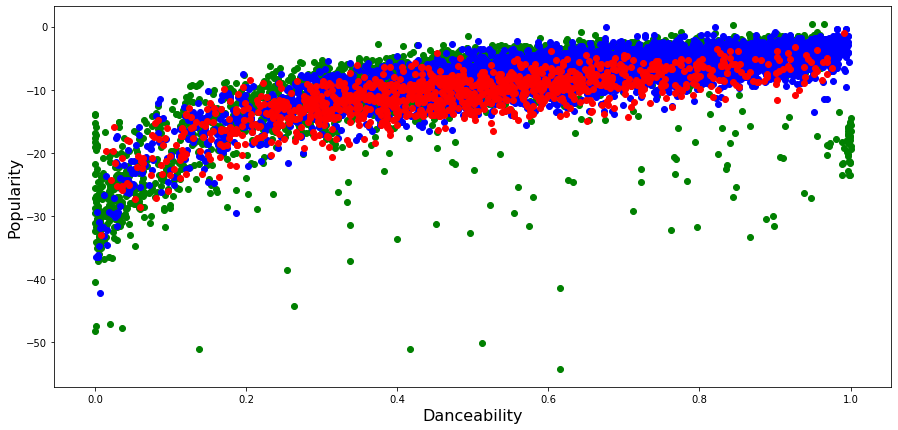

In [77]:
plt.figure(figsize = (15, 7))
plt.scatter(most_pop_15_20.energy.values, most_pop_15_20.loudness.values, color = "green")
plt.scatter(most_pop_00_12.energy.values, most_pop_00_12.loudness.values, color = "blue")
plt.scatter(most_pop_60_75.energy.values, most_pop_60_75.loudness.values, color = "red")
plt.ylabel("Popularity", fontsize = 16)
plt.xlabel("Danceability", fontsize = 16)

In [ ]:
plt.figure(figsize = (15, 7))
plt.scatter(most_pop_15_20.danceability.values, most_pop_15_20.tempo.values, color = "green")
plt.scatter(most_pop_00_12.danceability.values, most_pop_00_12.tempo.values, color = "blue")
plt.scatter(most_pop_60_75.danceability.values, most_pop_60_75.tempo.values, color = "red")
plt.ylabel("Popularity", fontsize = 16)
plt.xlabel("Danceability", fontsize = 16)

## Connect genres with artists and then with each song
df_genres is an extention of data by artists, artists serve to classify each song with each genre. Am assuming that if there is more than 1 artist, that both do the same genere